/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


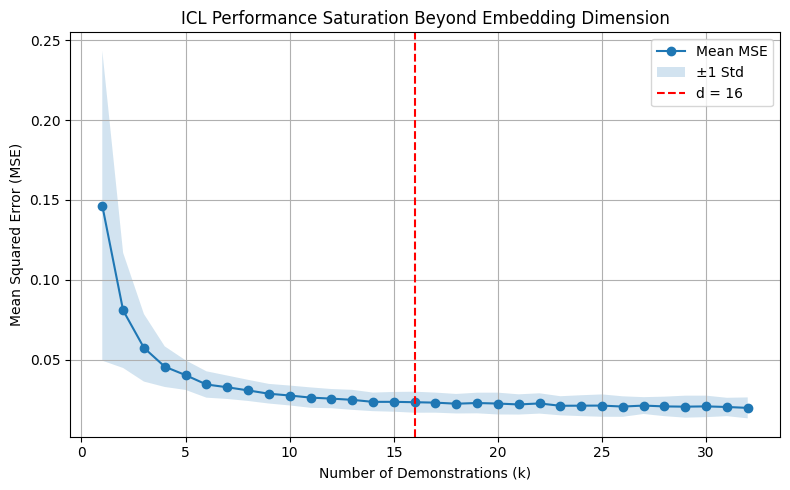

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# --- Config ---
d = 16           # input dimension
k_max = 32       # max number of demonstrations
n_test = 2000 #1000     # number of test queries per k
hidden_dim = 64  # transformer hidden size
n_layers = 2     # transformer depth
n_heads = 4
noise_std = 0.05
batch_size = 128  #64
num_seeds = 5

# Fixed true weight vector for consistency
W_FIXED = torch.randn(d)

# --- Toy Data Generator ---
def generate_batch(k, d, noise_std, batch_size):
    X = torch.randn(batch_size, k + 1, d)
    noise = noise_std * torch.randn(batch_size, k + 1)
    y = (X @ W_FIXED) + noise
    return X[:, :-1], y[:, :-1], X[:, -1], y[:, -1]

# --- Transformer Model ---
class ICLTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_heads, n_layers):
        super().__init__()
        self.input_proj = nn.Linear(input_dim + 1, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dropout=0.1, norm_first=True, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.output_proj = nn.Linear(hidden_dim, 1)

    def forward(self, x_support, y_support, x_query):
        B, k, d = x_support.shape
        device = x_support.device

        y_support = y_support.unsqueeze(-1)  # [B, k, 1]
        xy = torch.cat([x_support, y_support], dim=-1)  # [B, k, d+1]
        xq = torch.cat([x_query, torch.zeros(B, 1).to(device)], dim=-1).unsqueeze(1)  # [B, 1, d+1]
        seq = torch.cat([xy, xq], dim=1)  # [B, k+1, d+1]

        h = self.input_proj(seq)
        h = self.transformer(h)
        return self.output_proj(h[:, -1]).squeeze(-1)  # [B]

# --- Training Loop ---
def train_model(model, optimizer, criterion, epochs=1500):
    model.train()
    for epoch in range(epochs):
        x_sup, y_sup, x_q, y_q = generate_batch(k=16, d=d, noise_std=noise_std, batch_size=batch_size)
        optimizer.zero_grad()
        y_pred = model(x_sup, y_sup, x_q)
        loss = criterion(y_pred, y_q)
        loss.backward()
        optimizer.step()
        scheduler.step()

# --- Evaluation Loop ---
def evaluate_model(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for k in range(1, k_max + 1):
            mse = []
            for _ in range(n_test):
                x_sup, y_sup, x_q, y_q = generate_batch(k=k, d=d, noise_std=noise_std, batch_size=1)
                y_pred = model(x_sup, y_sup, x_q)
                mse.append(F.mse_loss(y_pred, y_q).item())
            avg_mse = np.mean(mse)
            losses.append(avg_mse)
    return losses

# --- Run Multi-Seed Experiment ---
all_losses = []
for seed in range(num_seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = ICLTransformer(input_dim=d, hidden_dim=hidden_dim, n_heads=n_heads, n_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
    criterion = nn.MSELoss()
    train_model(model, optimizer, criterion, epochs=10000)
    losses = evaluate_model(model)
    all_losses.append(losses)

# --- Aggregate and Plot ---
mean_losses = np.mean(all_losses, axis=0)
std_losses = np.std(all_losses, axis=0)

plt.figure(figsize=(8, 5))
ks = np.arange(1, k_max + 1)
plt.plot(ks, mean_losses, marker='o', label="Mean MSE")
plt.fill_between(ks, mean_losses - std_losses, mean_losses + std_losses, alpha=0.2, label="±1 Std")
plt.axvline(d, color='red', linestyle='--', label=f"d = {d}")
plt.xlabel("Number of Demonstrations (k)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("ICL Performance Saturation Beyond Embedding Dimension")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

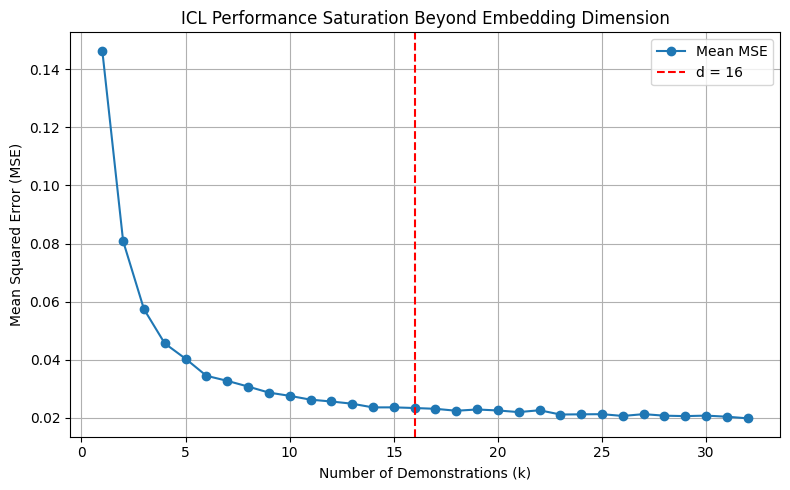

In [2]:
# plt.figure(figsize=(8, 5))
# ks = np.arange(1, k_max + 1)
# plt.plot(ks, mean_losses, marker='o', label="Mean MSE")
# # plt.fill_between(ks, mean_losses - std_losses, mean_losses + std_losses, alpha=0.2, label="±1 Std")
# plt.axvline(d, color='red', linestyle='--', label=f"d = {d}")
# plt.xlabel("Number of Demonstrations (k)")
# plt.ylabel("Mean Squared Error (MSE)")
# plt.title("ICL Performance Saturation Beyond Embedding Dimension")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [1]:
# for _ in range(n_test // batch_size):
#     x_sup, y_sup, x_q, y_q = generate_batch(k=k, d=d, noise_std=noise_std, batch_size=batch_size)
#     y_pred = model(x_sup, y_sup, x_q)
#     mse.append(F.mse_loss(y_pred, y_q).item())
